In [103]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from astropy.io import fits

%matplotlib notebook

Variables

In [104]:
outD = 7.77010  # primary diameter (m)
inD = 1.024  # inner M2 diameter (m)
m  = 8 

## GPI DM parameters
n = 48          # number sample points across the screen 
                # (Not the number of subapertures across the aperture which is less)
bign = n*m
nacross = 43.2    # number of subapertures across the aperture
    
## phase sample parameters
pscale = outD/(nacross)   #  pixel size (m) of samples in pupil plane
print(bigD)

384


aperture

In [105]:
x         = np.linspace(-(n)/2,(n)/2,n)*pscale 
y         = np.linspace(-(n)/2,(n)/2,n)*pscale
ax,ay     = np.meshgrid(x,y)
ar        = np.sqrt(ax**2+ay**2)
ap_outer  = (ar <= outD/2)
ap_inner  = (ar <= inD/2)   
aperture  = (ap_outer ^ ap_inner).astype(int)

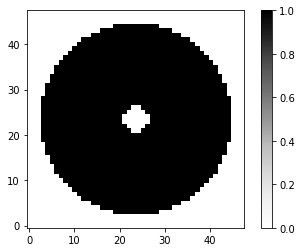

In [101]:
implot(aperture)

In [ ]:
if blackman:
    w  = np.blackman(48) 
    wx,wy = np.meshgrid(w,w)
    wr  = np.sqrt(wx**2 + wy**2) ## window radius        

open the file

In [106]:
filename = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_5.53.56_poldm_phase.fits"

hdulist = fits.open(filename,memmap=True)
pupil_phase = hdulist[0].data.astype('float')
#pdata = np.pad(data, ((0,0), (168,168), (168, 168)), 'constant')
    
# Get the phase dimensions
phdim = pupil_phase.shape 
phx   = phdim[1]
phy   = phdim[2]
timesteps = phdim[0]

print(phdim)

(21899, 48, 48)


Compute 2d fourier transform

In [107]:
phFT = np.zeros((timesteps,phx,phy), dtype=complex)
for t in np.arange(timesteps):
    phFT[t,:,:] = fft.fftshift(fft.fft2(pupil_phase[t,:,:]*aperture))/(phx*phy)
print('Done with FT')

Done with FT


Make frequency grid

In [108]:
kx = fft.fftshift(fft.fftfreq(phx,pscale))
ky = fft.fftshift(fft.fftfreq(phy,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

Make psd

In [109]:
psd2D = np.zeros((timesteps, phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
        
varpsd = np.sum(psd2D, axis=0)

psd plot

In [6]:
def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()

In [123]:
def PSDplot(psd, freq, display=True, **kwargs):
    """Plot the 1D psd"""
    
    ##  create matplotlib figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    par = np.polyfit(np.log10(freq[freq>0]),np.log10(psd[freq>0]), deg = 1)
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog(freq[freq>0],psd[freq>0],'b.',freq[freq>0],(10**intercept)*freq[freq>0]**slope, 'r')
    
    #img = ax.loglog(freq,smoothed, 'r')
    ax.legend(['PSD', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)], loc=3, fontsize=10)
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='grey', linestyle='-')
    ax.set_ylabel('Power Spectrum')
    ax.set_xlabel('Spatial Frequency')
    
    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=10)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=15)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=15)
    if display: plt.show()

1d psd plot

<IPython.core.display.Javascript object>


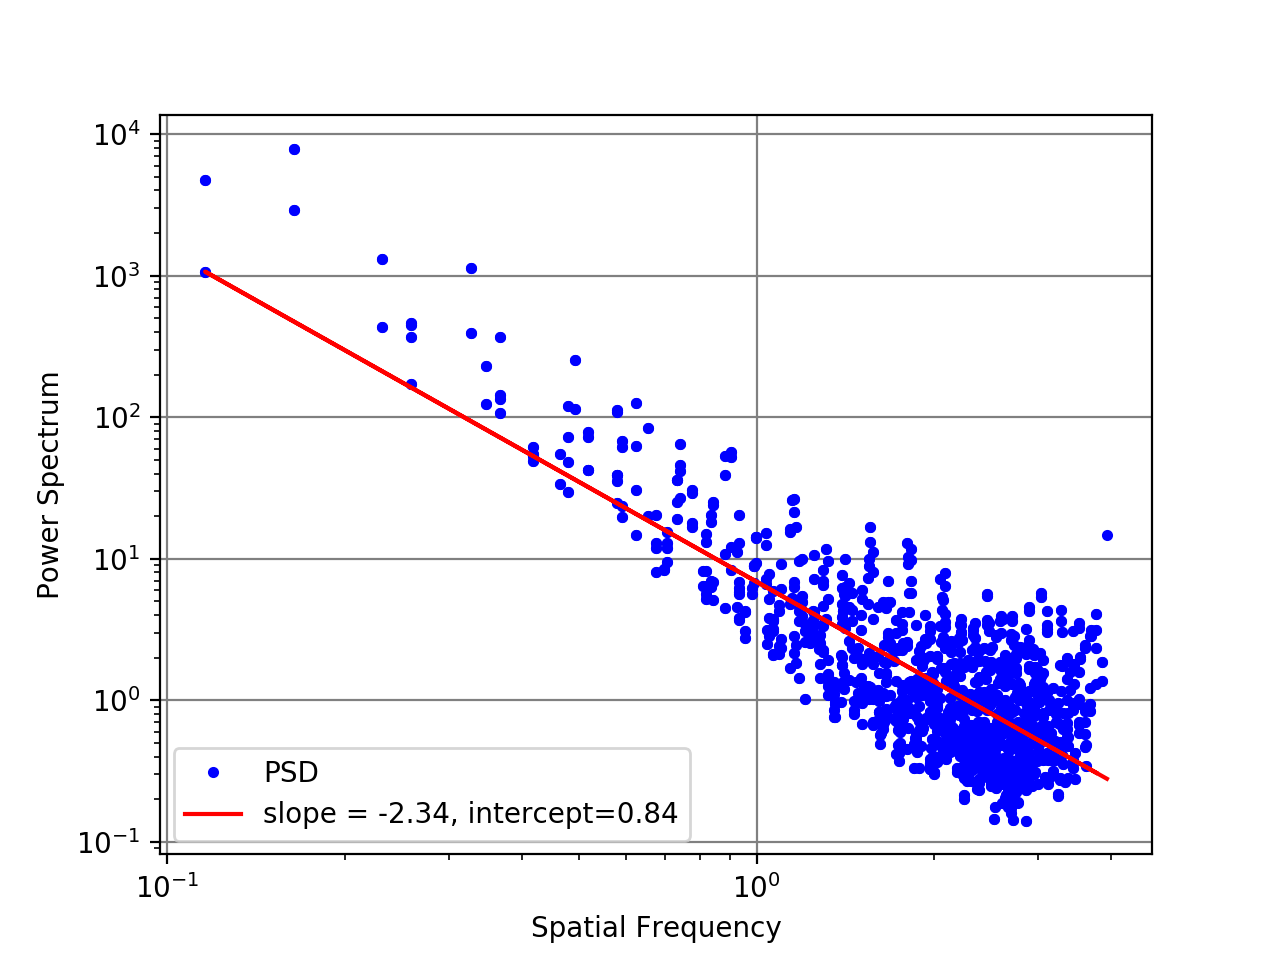

In [124]:
PSDplot(varpsd,kr)